2025-09-11 09:45:24.218593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757576724.237012 3842241 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757576724.242516 3842241 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757576724.257484 3842241 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757576724.257505 3842241 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757576724.257507 3842241 computation_placer.cc:177] computation placer alr

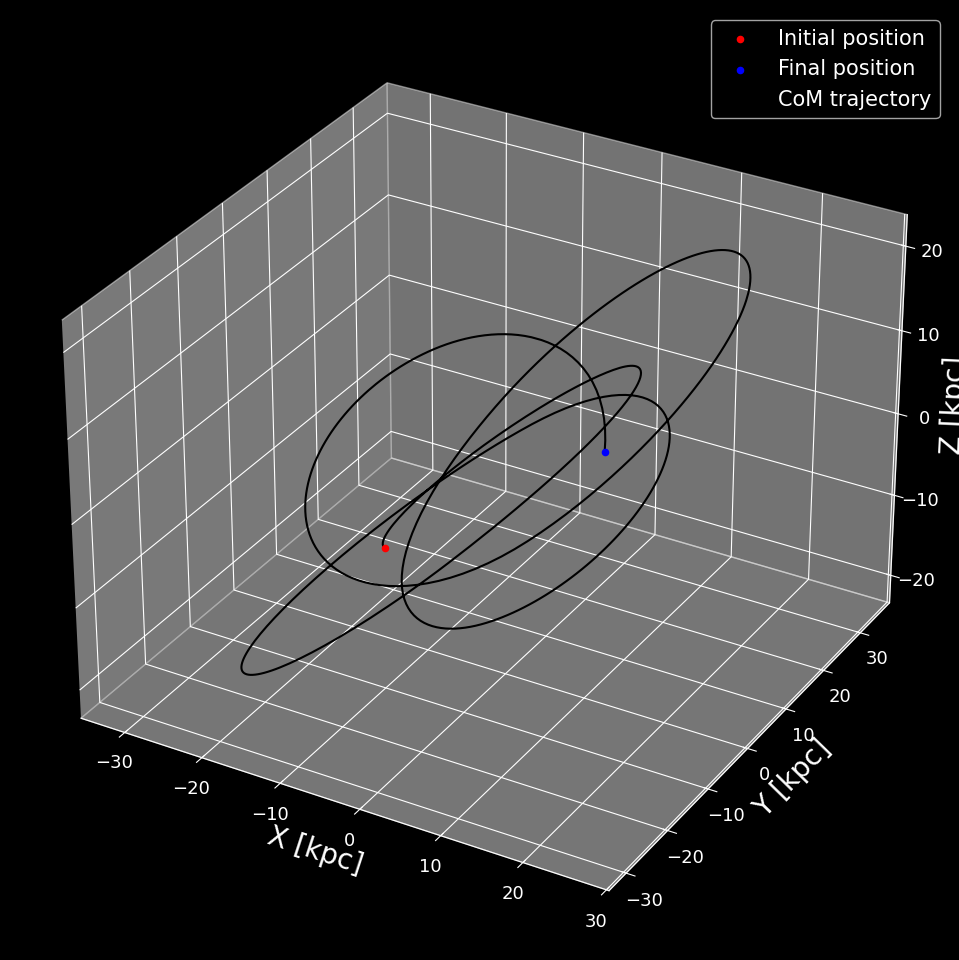

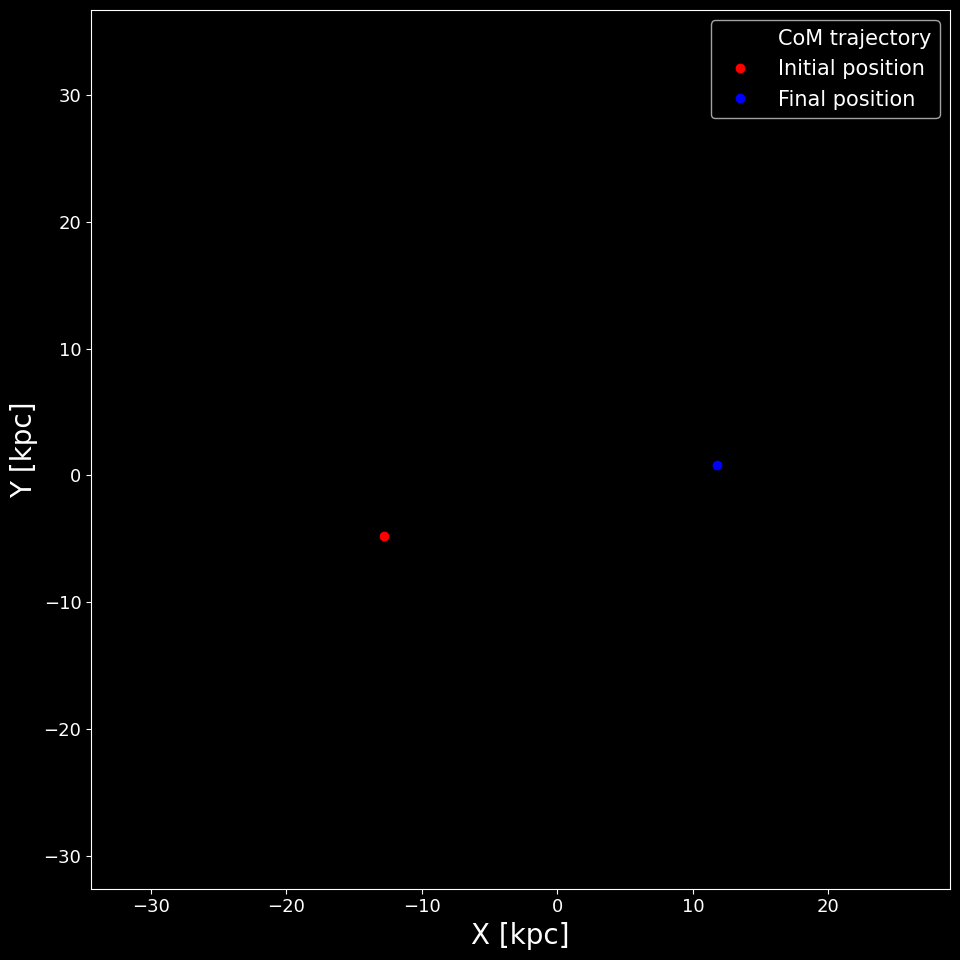

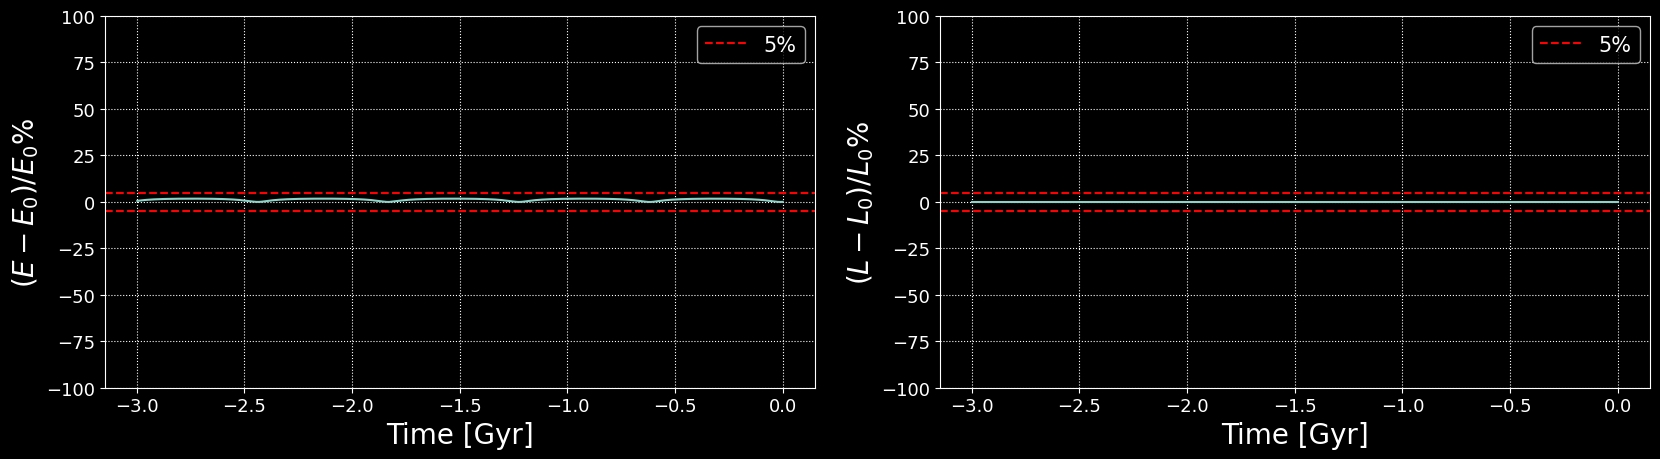

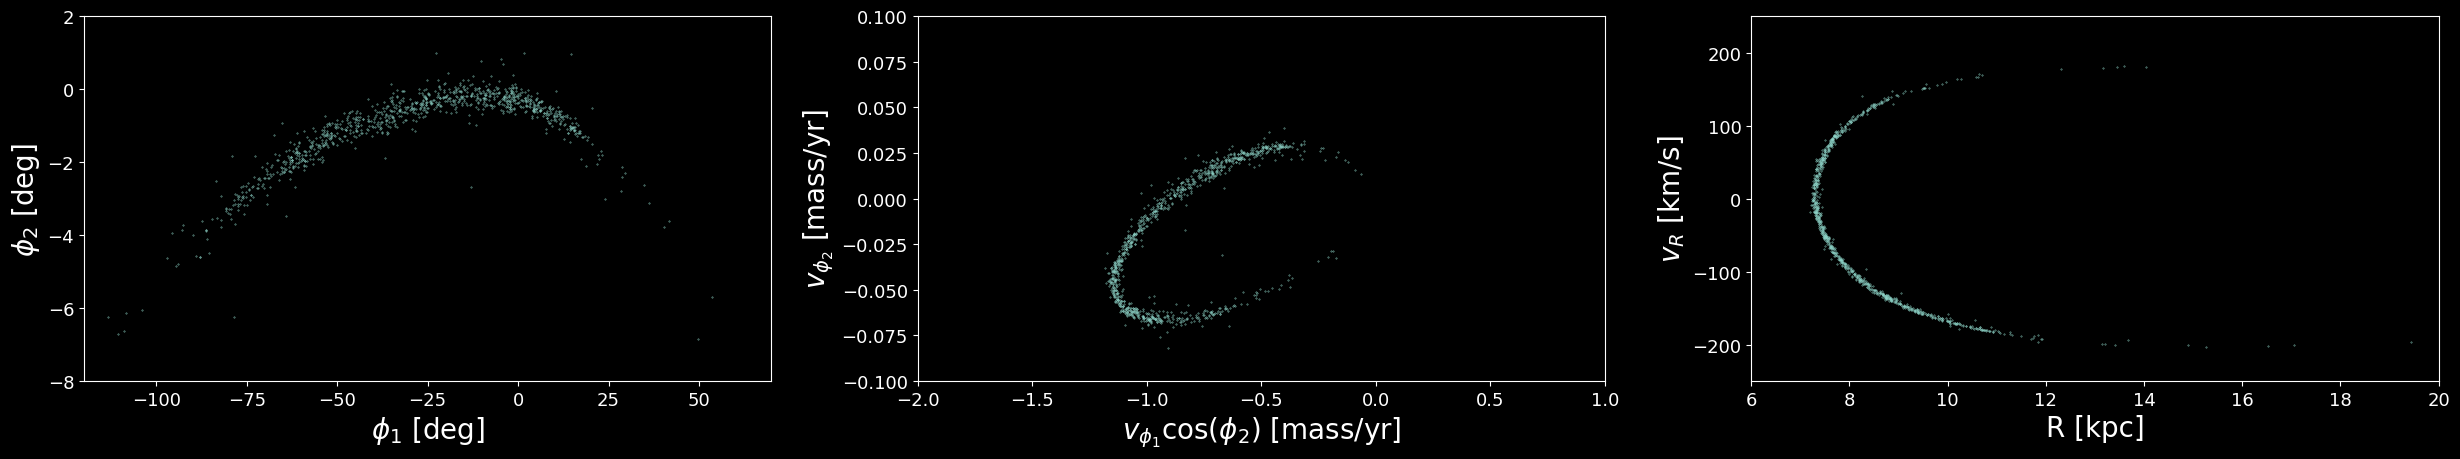

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '6, 7, 8, 9, ' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions


# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  
# code_units = CodeUnits(code_length, code_mass, G=G)  # default values


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 500, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
# config_com = config._replace(return_snapshots=True,)
# config_com = config._replace(num_snapshots=500, )
params_com = params._replace(t_end=-params.t_end,)



#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

final_positions = final_positions * code_units.code_length.to(u.kpc)
final_velocities = final_velocities * code_units.code_velocity.to(u.kpc / u.Myr)

s = projection_on_GD1(final_state, code_units=code_units,)
R = s[:, 0]  # kpc
phi1 = s[:, 1]  # deg
phi2 = s[:, 2]  # deg
vR = s[:, 3]  # km/s
v1_cosphi2 = s[:, 4]  # mass/yr
v2 = s[:, 5]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1_cosphi2 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


stream_target = s

In [ ]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,
                         N_particles = 1000, )
config_com = config_com._replace(return_snapshots=False,)


# @jit
def time_integration_NFW_mass_grad(Mvir):

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(0)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])

    return stream
   
    
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)

# @jit
def log_diag_multivariate_normal(x, mean, sigma):
    """
    Log PDF of a multivariate Gaussian with diagonal covariance.
    
    Parameters
    ----------
    x : (D,)
    mean : (D,)
    sigma : (D,)  # standard deviations
    """
    diff = (x - mean) / sigma
    D = x.shape[0]
    log_det = 2.0 * jnp.sum(jnp.log(sigma))
    norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
    exponent = -0.5 * jnp.sum(diff**2)
    return norm_const + exponent


def stream_likelihood_diag(model_stream, obs_stream, obs_errors):
    """
    Log-likelihood of observed stars given simulated stream (diagonal covariance).
    
    Parameters
    ----------
    model_stream : (N_model, D)
    obs_stream   : (N_obs, D)
    obs_errors   : (N_obs, D)  # per-observation standard deviations
    """

    def obs_log_prob(obs, sigma):
        # For a single observed point, compute log p(obs | model mixture)
        def model_log_prob(model_point):
            return log_diag_multivariate_normal(obs, model_point, sigma)

        log_probs = jax.vmap(model_log_prob)(model_stream)  # (N_model,)
        # normalized mixture: uniform weights 1/N
        log_p_stream = logsumexp(log_probs) - jnp.log(model_stream.shape[0])
        return log_p_stream

    # Vectorize across all observations
    logL_values = jax.vmap(obs_log_prob)(obs_stream, obs_errors)  # (N_obs,)

    # Return *total* log-likelihood (sum, not mean!)
    return jnp.sum(logL_values)

@jax.jit
def log_likelihood(params):
    stream = time_integration_NFW_mass_grad(params)
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.001])
    # dist = tfd.MultivariateNormalDiag(loc=stream,
    #                                 scale_diag=jnp.diag(noise_std).repeat(1000))
    # return dist.log_prob(stream_target)

    dist = tfd.Independent(
        tfd.Normal(loc=stream, scale=noise_std[None, :]),  # Broadcast noise_std
        reinterpreted_batch_ndims=1  # Treat last dimension as event dimension
    )

     # Add prior (example: log-uniform prior on Mvir in [1e10, 1e13])
    log_prior = tfd.Uniform(low=1/2*4.3683325e11*u.Msun.to(code_units.code_mass), high=2* 4.3683325e11*u.Msun.to(code_units.code_mass)).log_prob(params)

    return jnp.sum(dist.log_prob(stream_target)) + log_prior.sum()

In [ ]:
# We can batch the log likelihood
batched_log_likelihood = jax.vmap(log_likelihood)

n_sim = 1
keys = jnp.arange(n_sim)
# init_params = jnp.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim) 
init_params = jnp.array([params.NFW_params.Mvir*(0.8)])

In [50]:
init_params

Array([39314992.], dtype=float32)

In [ ]:
nuts = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=log_likelihood,
        # num_leapfrog_steps=15,
        step_size=5e9*u.Msun.to(code_units.code_mass),
        )

# adaptive_nuts = tfp.mcmc.DualAveragingStepSizeAdaptation(
#     inner_kernel=nuts,
#     num_adaptation_steps=int(0.8 * 30),
#     step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(step_size=new_step_size),
#     step_size_getter_fn=lambda pkr: pkr.step_size,
#     log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
# )

In [56]:
samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=100, # Use 200 samples or more to get nice posterior but it takes time
    num_burnin_steps=20,
    current_state=init_params[0],
    kernel=nuts,
    trace_fn=lambda _, pkr: pkr.is_accepted,
    seed=jax.random.PRNGKey(0))



In [57]:
jnp.mean(is_accepted)

Array(0., dtype=float32)

In [60]:
samples[is_accepted]

Array([], shape=(0,), dtype=float32)

In [62]:
samples

Array([39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 39314992., 39314992.,
       39314992., 39314992., 39314992., 39314992., 